# Tweet Sentiment Extraction

In this kaggle competetion, we need to predict the selected text from text feature in the test data set which best supports the sentiment.

Kaggle Dataset - https://www.kaggle.com/competitions/tweet-sentiment-extraction

# EDA

In [1]:
#importing required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import plotly.figure_factory as ff
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#set display option for rows & columns

pd.set_option( 'display.max_rows', None)
pd.set_option('display.max_columns', None )

In [4]:

train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tweet Sentiment/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tweet Sentiment/test.csv')



In [5]:
print("Shape of train data : ",train_df.shape)
print("shape of test data  : ",test_df.shape)

Shape of train data :  (27481, 4)
shape of test data  :  (3534, 3)


In [6]:
train_df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
#Same row/datapoint has missing value for text and selected text column 
train_df[train_df['selected_text'].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [8]:
# dropping the missing values
train_df.dropna(axis=0, how='any', inplace=True)

In [9]:
#resetting index
train_df.reset_index(inplace = True, drop = True)

In [10]:
print("Shape of train data : ",train_df.shape)
print("shape of test data  : ",test_df.shape)

Shape of train data :  (27480, 4)
shape of test data  :  (3534, 3)


After removing null values datashape no of datapoints are reduced to 1, since same row has missing values for two columns, selected_text and text.

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [12]:
train_df.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


In [13]:
test_df.head(3)

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative


In [14]:
train_df.columns.to_list()

['textID', 'text', 'selected_text', 'sentiment']

In [15]:
test_df.columns.to_list()

['textID', 'text', 'sentiment']

In [16]:
temp = train_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Pastel1')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


Observation

1) We have 4 features in train data.

2) Train data had one null value which was dropped.

3) The selected text column values needs to be predicted for test data.

4) There are 3 different type os sentiment - Neutral, Positive and Negative


Sample sentiment

In [17]:
# positive tweet
print(f"Positive tweet example: {train_df[train_df['sentiment'] == 'positive']['text'].values[0]}")

# negative tweet
print(f"Negative tweet example: {train_df[train_df['sentiment'] == 'negative']['text'].values[0]}")

# neutral tweet
print(f"Neutral tweet example: {train_df[train_df['sentiment'] == 'neutral']['text'].values[0]}")

Positive tweet example: 2am feedings for the baby are fun when he is all smiles and coos
Negative tweet example:  Sooo SAD I will miss you here in San Diego!!!
Neutral tweet example:  I`d have responded, if I were going


In [18]:
train_df["sentiment"].value_counts(normalize = True).mul(100).round(1).astype(str) + '%'

neutral     40.5%
positive    31.2%
negative    28.3%
Name: sentiment, dtype: object

In [19]:
test_df["sentiment"].value_counts(normalize = True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

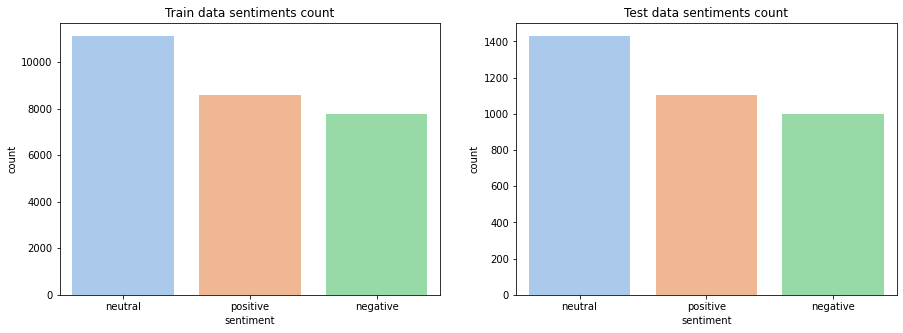

In [20]:
f, axes = plt.subplots(1, 2,figsize=(15,5))

sns.countplot(x='sentiment', data=train_df, palette='pastel', order=train_df.sentiment.value_counts().index, ax=axes[0])\
.set_title('Train data sentiments count');

sns.countplot(x='sentiment', data=test_df, palette='pastel' , order=test_df.sentiment.value_counts().index, ax=axes[1]);
plt.title('Test data sentiments count');

Observation:

1) Both train and test data have similar kind of distribution.

2) There are three categories of sentiment: neutral, positive, negative with neutral being largest in number followed by postivite and negative.

3) Positive and negative sentiment are also large in number. Hence, the dataset in not imbalaced.

Jaccard Similarity

Let's look at how similar the selected text and text are using jaccard similarity.

In [21]:
def Jaccard_Similarity_Score(doc1, doc2):
 
 # List the unique words in a document
 words_doc1 = set(doc1.lower().split())
 words_doc2 = set(doc2.lower().split())
 
 # Find the intersection of words list in doc1, doc2
 intersection = words_doc1.intersection(words_doc2)
 # Find the union of words list of word doc1, doc2
 union = words_doc1.union(words_doc2)
 
 # return Jaccard similarity score 
 return float(len(intersection)) / len(union)

In [22]:
results_jaccard = []

for ind, row in train_df.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text
    
    # Jaccard score similarity
    jaccard_score = Jaccard_Similarity_Score(sentence1, sentence2)
    results_jaccard.append([sentence1, sentence2, jaccard_score])

In [23]:
jaccard = pd.DataFrame(results_jaccard, columns = ["text","selected_text","jaccard_score"])
train_df = train_df.merge(jaccard, how = 'outer')

In [24]:
train_df.groupby('sentiment')['jaccard_score'].value_counts().nlargest(3)

sentiment  jaccard_score
neutral    1.0              10012
negative   1.0               1143
positive   1.0               1124
Name: jaccard_score, dtype: int64

Generating Metafeatures for analysing text and selected_text features.

In [25]:
# Finding number of words in selected text
train_df['Num_words_ST'] = train_df['selected_text'].apply(lambda x:len(str(x).split())) 

# Finding number of words in actual text
train_df['Num_word_text'] = train_df['text'].apply(lambda x:len(str(x).split()))

# Difference in no. of word texr and selected text
train_df['difference_in_words'] = train_df['Num_word_text'] - train_df['Num_words_ST'] 

In [26]:
train_df.head(4)

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2


In [27]:
print('The max length tweet for train data is:', train_df['Num_word_text'].max()) 
print('the min length tweet for train data is:', train_df['Num_word_text'].min())


The max length tweet for train data is: 33
the min length tweet for train data is: 1


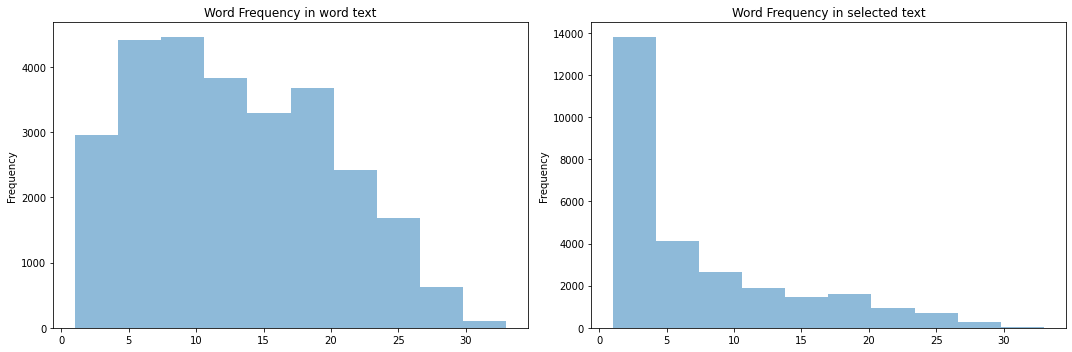

In [28]:
#import matplotlib.pyplot as plt
plt.subplot(1,2,1)
train_df['Num_word_text'].plot.hist(alpha = 0.5,figsize=(15, 5))
plt.title('Word Frequency in word text')
plt.subplot(1,2,2) 
train_df['Num_words_ST'].plot.hist(alpha = 0.5,figsize=(15, 5))
plt.title('Word Frequency in selected text')
plt.tight_layout() 
plt.show() 


Visulaization of neural tweets

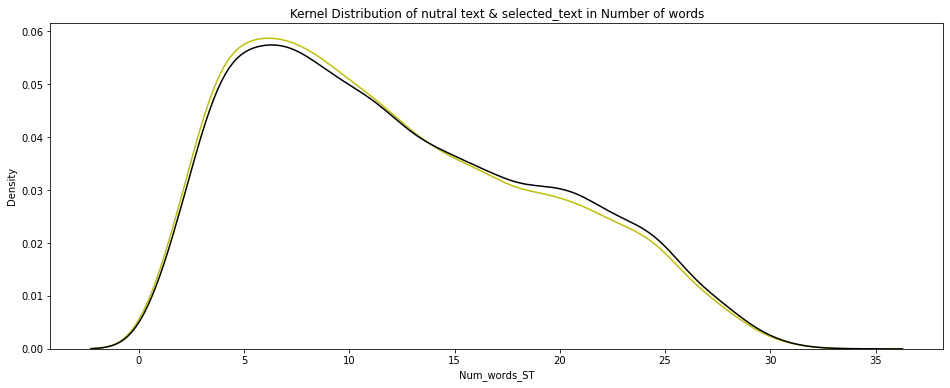

In [29]:
plt.figure(figsize = (16,6))
p1 = sns.kdeplot(train_df[train_df['sentiment']=='neutral']['Num_words_ST'],color = "y").set_title('Kernel Distribution of nutral text & selected_text in Number of words')
p1 = sns.kdeplot(train_df[train_df['sentiment']=='neutral']['Num_word_text'], color = "black")
plt.show()

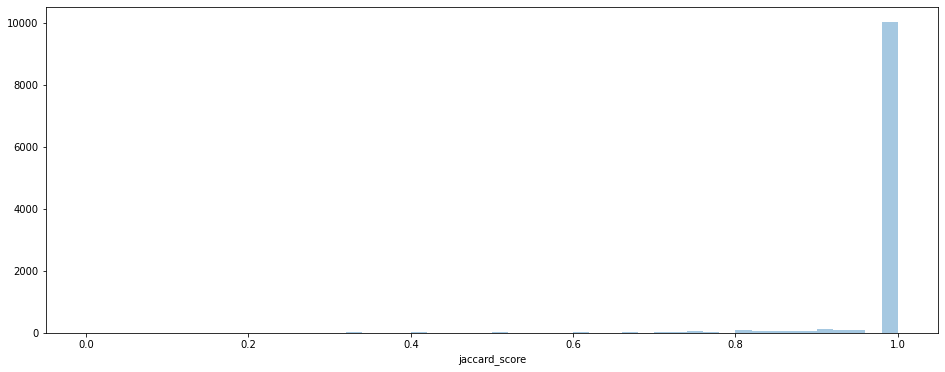

In [30]:
plt.figure(figsize = (16,6))
sns.distplot(train_df[train_df['sentiment']=='neutral']['jaccard_score'], kde = False);

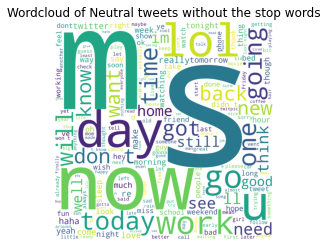

In [31]:
neutral_tweets = train_df['selected_text'][train_df['sentiment']=='neutral']

#Wordcloud of neutral tweets without having stop words

stopwords = set(STOPWORDS)
neutral_text = " ".join(list(neutral_tweets.values))

wordcloudNeutral = WordCloud(width = 1600, height = 1600, 
                background_color ='white',
                stopwords = stopwords,                
                min_font_size = 11).generate(neutral_text)
plt.axis("off")
plt.title('Wordcloud of Neutral tweets without the stop words')
plt.imshow(wordcloudNeutral)
plt.show()
     

Observation:

1) We can see that text and selected text has same distribution as both are overlapping eachother.

2) Many tweet have jaccard similarity score as 1, which implies many test and selected text are same for neutral tweets.

3) Also we can observed most of selected_text and text word count range between 5 to 15 and max upto 30 word count.


Visulaization of positive tweets

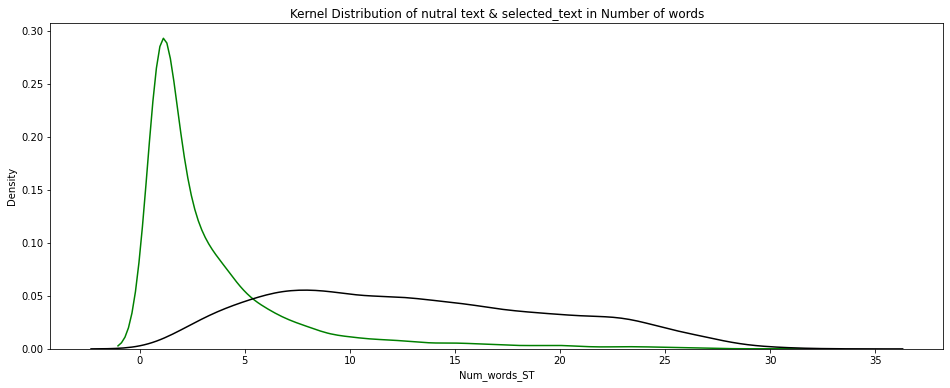

In [32]:
plt.figure(figsize = (16, 6))
p1 = sns.kdeplot(train_df[train_df['sentiment']=='positive']['Num_words_ST'], color = "g").set_title('Kernel Distribution of nutral text & selected_text in Number of words')
p1 = sns.kdeplot(train_df[train_df['sentiment']=='positive']['Num_word_text'], color = "black")
plt.show()

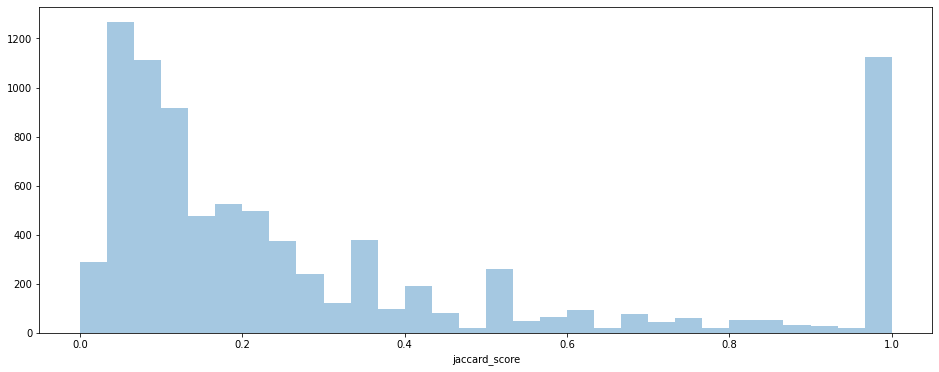

In [33]:
plt.figure(figsize = (16,6))
sns.distplot(train_df[train_df['sentiment'] == 'positive']['jaccard_score'], kde = False);

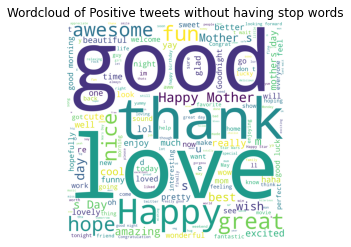

In [34]:
positive_tweets = train_df['selected_text'][train_df['sentiment'] == 'positive']

#Wordcloud of positive tweets without the stop words

stopwords=set(STOPWORDS)
positive_text=" ".join(list(positive_tweets.values))

wordcloudPositive = WordCloud(width = 1600, height = 1600, 
                background_color ='white',
                stopwords = stopwords,                
                min_font_size = 10).generate(positive_text)
plt.axis("off")
plt.title('Wordcloud of Positive tweets without having stop words')
plt.imshow(wordcloudPositive)
plt.show()
     

Observation

1) We can see that text and selected text has big difference in distribution. In this case select_text is not as same as text.

2) Also we can observed most of selected_text word count range between 0 to 5 and text range between 5 to 20.

3) Jaccard score have a distributed values.


Visulaization of negative tweets

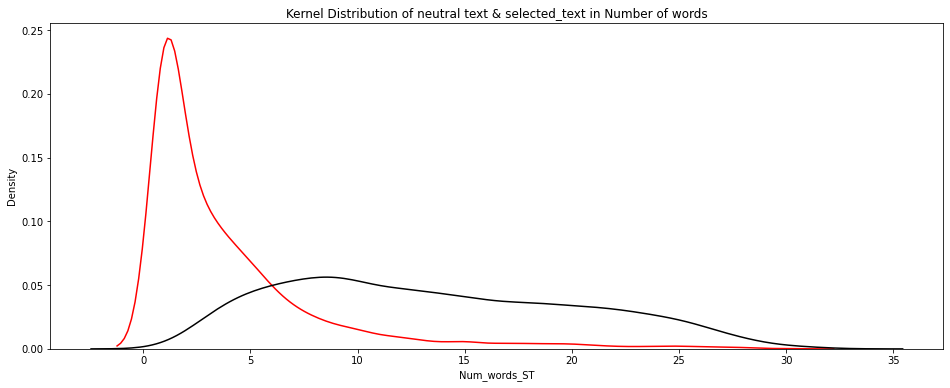

In [35]:
plt.figure(figsize = (16, 6))
p1 = sns.kdeplot(train_df[train_df['sentiment'] == 'negative']['Num_words_ST'], color="red").set_title('Kernel Distribution of neutral text & selected_text in Number of words')
p1 = sns.kdeplot(train_df[train_df['sentiment'] == 'negative']['Num_word_text'], color="black")
plt.show()

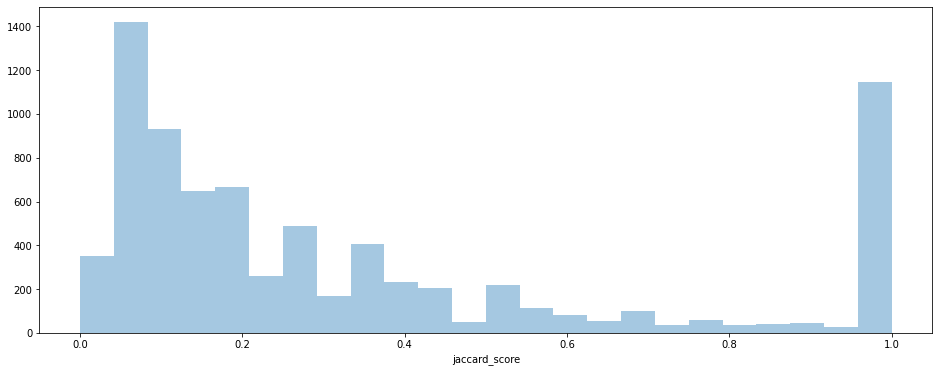

In [36]:
plt.figure(figsize = (16,6))
sns.distplot(train_df[train_df['sentiment'] == 'negative']['jaccard_score'], kde = False);

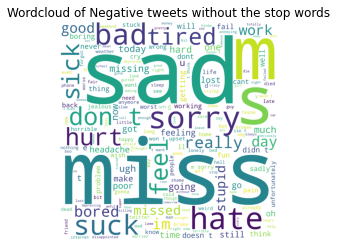

In [37]:
negative_tweets = train_df['selected_text'][train_df['sentiment'] == 'negative']

#Wordcloud of negative tweets without having stop words

stopwords=set(STOPWORDS)
negative_text=" ".join(list(negative_tweets.values))

wordcloudNegative = WordCloud(width = 1600, height = 1600, 
                background_color ='white',
                stopwords = stopwords,                
                min_font_size = 10).generate(negative_text)
plt.axis("off")
plt.title('Wordcloud of Negative tweets without the stop words')
plt.imshow(wordcloudNegative)
plt.show()
     

Observation:

1) We can see that text and selected text has big difference distribution.

2) In this case many select_text is not as same as text.

3) Jaccard values are distributed across different range. And word like sad, sorry, miss are more frequent.

Sentiment difference

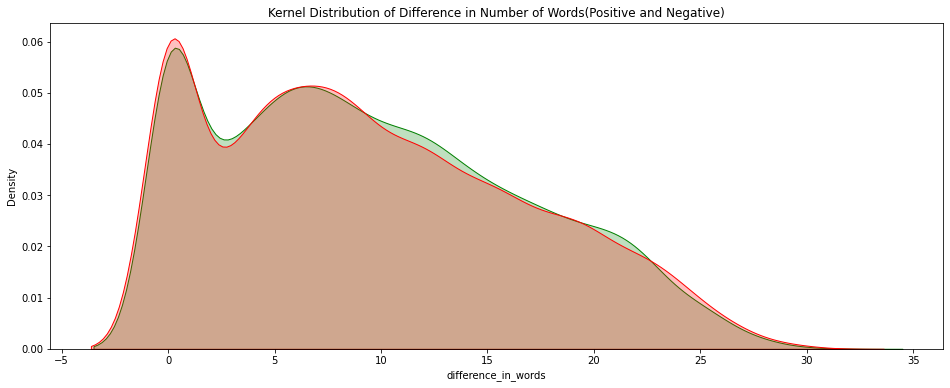

In [38]:
plt.figure(figsize = (16,6))
p1 = sns.kdeplot(train_df[train_df['sentiment'] == 'positive']['difference_in_words'], shade = True, color = 'g').set_title("Kernel Distribution of Difference in Number of Words(Positive and Negative)")
p2 = sns.kdeplot(train_df[train_df['sentiment'] == 'negative']['difference_in_words'], shade = True, color = 'r')


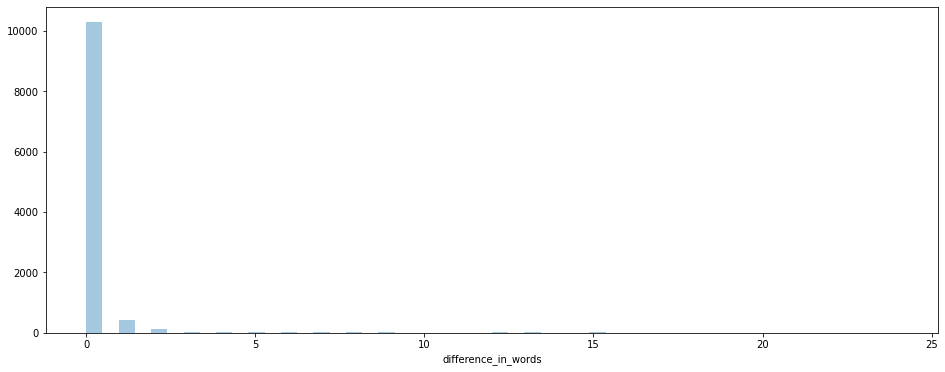

In [39]:
plt.figure(figsize = (16,6))
sns.distplot(train_df[train_df['sentiment']=='neutral']['difference_in_words'], kde = False);

Jaccard Similarity

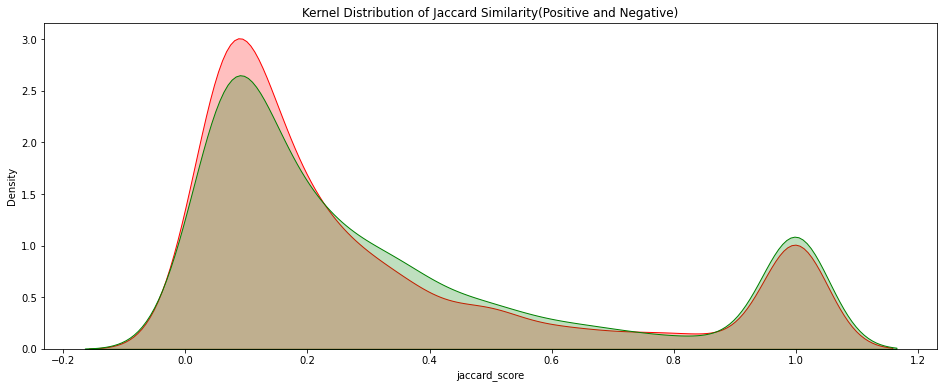

In [40]:
plt.figure(figsize=(16,6))
p1 = sns.kdeplot(train_df[train_df['sentiment']=='positive']['jaccard_score'], shade = True, color='r').set_title("Kernel Distribution of Jaccard Similarity(Positive and Negative)")
p2 = sns.kdeplot(train_df[train_df['sentiment']=='negative']['jaccard_score'], shade = True, color='g')

# Preprocessing

There are few string where specical charater (`) is present instead of apostrophe ('). Lets replace these special character first from train and test data in text columns.

In [41]:
def removespecifchar(df):
  special_characters = "`"
  for k in range(len(df)):
    if(special_characters in df[k]):
      df[k]=df[k].replace("`","'") 

#Train dataset
removespecifchar(train_df['text'])
removespecifchar(train_df['selected_text'])

#Test dataset
removespecifchar(test_df['text'])
     


In [42]:
contrations = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}
     

In [43]:
def decontracted(text):
  for word in text.split():
    if word.lower() in contrations:
        text = text.replace(word, contrations[word.lower()])
    return text

In [44]:
#Train dataset
train_df['text'] = train_df['text'].apply(lambda text: decontracted(text))
train_df['selected_text'] = train_df['selected_text'].apply(lambda text: decontracted(text))

#Test dataset
test_df['text'] = test_df['text'].apply(lambda text: decontracted(text))

In [45]:
def clean_text(text):
    ''' 
        1) Making text lowercase 
        2) Remove text in square brackets
        3) Remove links
        4) Remove punctuation,
           and remove words containing numbers.

    '''

    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [46]:
#Train dataset
train_df['text'] = train_df['text'].apply(lambda x:clean_text(x))
train_df['selected_text'] = train_df['selected_text'].apply(lambda x:clean_text(x))

# test dataset
test_df['text'] = test_df['text'].apply(lambda text: clean_text(text))

Empty strings row check and removing

In [47]:
train_df=train_df[train_df["selected_text"]!=""]

In [48]:
train_df=train_df[train_df["text"]!=""]

In [49]:
# After removing the empty colume rows, retting the index
train_df.reset_index(inplace = True, drop = True)

In [50]:
print(train_df.shape,test_df.shape)


(27376, 8) (3534, 3)


In [51]:
#removing Stopwords

from nltk.corpus import stopwords, wordnet
def remove_Stopwords(text):

    #to get the english stopwords
    stopW = stopwords.words('english')
    return " ".join([i for i in text.split() if i not in stopW])



In [52]:
train_df['clean_text'] = train_df['text'].apply(lambda x:remove_Stopwords(x))

In [53]:
train_df.head(3)

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,clean_text
0,cb774db0d1,i would have responded if i were going,i would have responded if i were going,neutral,1.000000,7,7,0,would responded going
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8,sooo sad miss san diego
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3,boss bullying


In [54]:
# Neutral sentiment data 
from collections import Counter
count_n = Counter(" ".join(train_df[train_df["sentiment"] == "neutral"]["text"]).split()).most_common(20)
Nuteraltemp = pd.DataFrame(count_n)
Nuteraltemp.columns = ['Common_words', 'count']

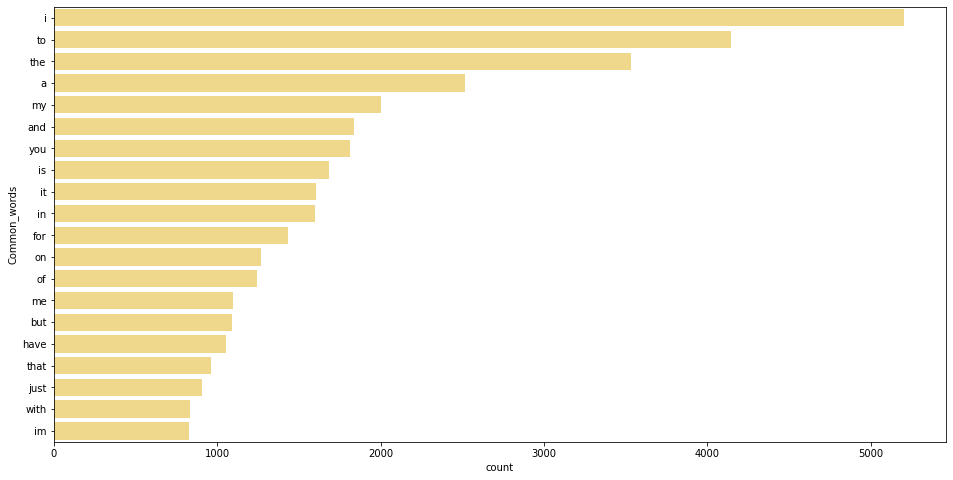

In [55]:
fig, ax = plt.subplots(figsize = (16,8))
sns.barplot(x = 'count',
 y = 'Common_words',
 data = Nuteraltemp, color = '#FBDD7E', saturation = 0.8)
plt.show()

In [56]:
# Positive sentiment data 
count_n = Counter(" ".join(train_df[train_df["sentiment"] == "positive"]["text"]).split()).most_common(20)
temp = pd.DataFrame(count_n)
temp.columns = ['Common_words','count']

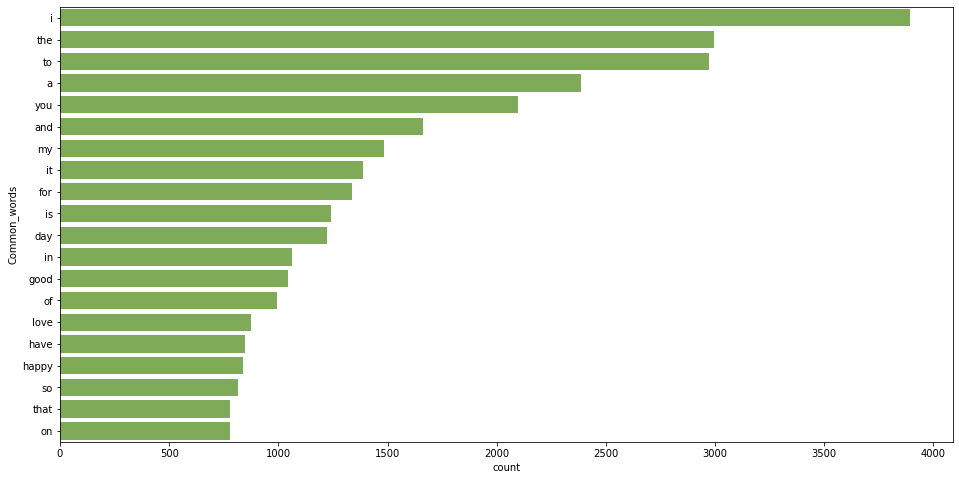

In [57]:
fig, ax = plt.subplots(figsize = (16,8))
sns.barplot(x = 'count',
 y = 'Common_words',
 data = temp, color = '#7eb54e', saturation = 0.8)
plt.show()

In [58]:
# Negative sentiment Data
count_n = Counter(" ".join(train_df[train_df["sentiment"] == "negative"]["text"]).split()).most_common(20)
temp = pd.DataFrame(count_n)
#common counts
temp.columns = ['Common_words','count']

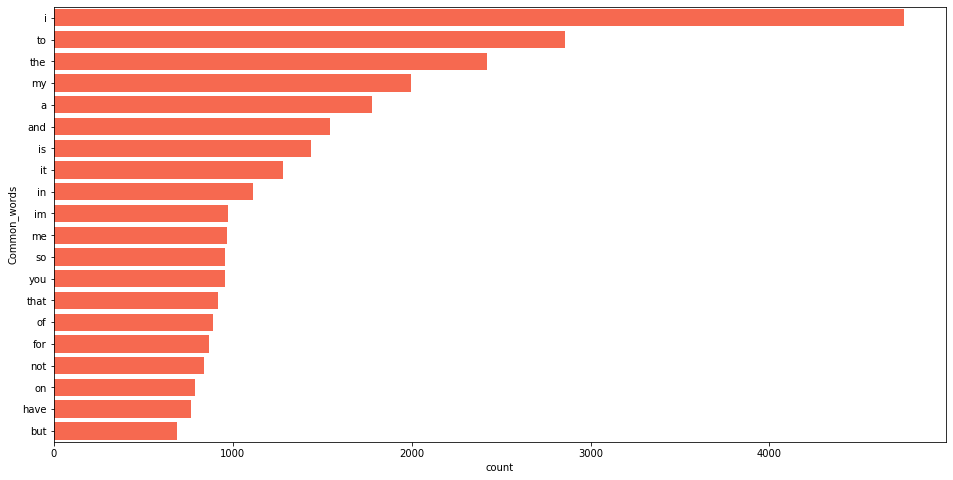

In [59]:
fig,ax = plt.subplots(figsize=(16,8))
sns.barplot(x = 'count',
 y = 'Common_words',
 data = temp, color = '#FF6347', saturation = 0.9)
plt.show()

In [60]:
train_df = train_df[['textID','text','selected_text','sentiment']]

In [61]:
print(train_df.head(2))
print("*************************************************************************************")
print(test_df.head(2))

       textID                                         text  \
0  cb774db0d1       i would have responded if i were going   
1  549e992a42   sooo sad i will miss you here in san diego   

                            selected_text sentiment  
0  i would have responded if i were going   neutral  
1                                sooo sad  negative  
*************************************************************************************
       textID                                               text sentiment
0  f87dea47db                          last session of the day     neutral
1  96d74cb729   shanghai is also really exciting precisely  s...  positive


In [62]:

# saving the train preprocessed dataframe 
train_df.to_csv('/content/drive/My Drive/Colab Notebooks/Tweet Sentiment/train_preprocess.csv',index=False)
test_df.to_csv('/content/drive/My Drive/Colab Notebooks/Tweet Sentiment/test_preprocess.csv',index=False)

Conclusions:

1) We have three different types of sentiment. Neutral sentiment has the largest number of tweets followed by positive and negative sentiment.

2) Majority of neutral tweets has jaccard similarity score as 1. This conclude that text and selected text are mostly the same for neutral tweets.

3) There are large number of tweets with word length 5 to 7 irrespective of sentiment value. The tweets which are having number of words greater than 25 are very less and hence, words distribution plot is right skewed.

4) Positive and negative tweets jaccard score have high kurtosis and thus values are concentrated in two regions narrow and high density.

5) Neutral sentiment has higher no. of words in the selected_text compared to postive and negative sentiment.
Also, around 92% of neutral tweets have equal word length with selected_text and high Jaccard score of 1. Thus, neutral tweets can be returned as it is as the selected_text.

6) Selected text is copy paste of a part of the text, so cleaning the data may not be feasible here, we will see whether cleaning data improves model performance during modelling.

7) Postive and negative sentiment have similar distribution for difference in word length and jaccard score.

8) We can see from the jaccard score plot that there is peak for negative and positive plot around score of 1. This means there is a cluster of tweets where there is a high similarity between text and selected texts, if we can find those clusters then we can predict text for selected texts for those tweets irrespective of the sentiment type.

9) We created word cloud and got significant textual points which are highlighted with larger size in word cloud and are contibuted as per given sentiment. These plays a key role i the predictions of selected text.
From word cloud, we can see words like I, to, the, go, dont, got, u, cant,lol, like are common in all three segments. That's interesting because words like don't and can't are more of negative nature and word like lol is kind of positive nature word.

10) After ploting 20 bar graph of common word found these word also highlighted in word cloud. These are most frequest word which are appearing in the word corpus.
